# Trying out basic openai gym and stable baselines stuff

## Let's start with some code based off the snippet in the stable baselines readme:

Create an environment for CartPole-v1

In [1]:
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.ppo2 import PPO2

env_cartpole = gym.make('CartPole-v1')
env_cartpole = DummyVecEnv([lambda: env_cartpole])  #` The algorithms require a vectorized environment to run

Use PPO2 (just because it was in the example) to train an agent, and keep track of how many steps each run lasts. There's a lot of output, so we'll set verbosity to 0. 

In [2]:
model_ppo2 = PPO2(MlpPolicy, env_cartpole, verbose=0)
env_cartpole.reset()
model_ppo2.learn(total_timesteps=25000)

W0814 21:31:29.220499 140328486889280 deprecation_wrapper.py:119] From /home/rishabh/anaconda3/envs/rl-env/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0814 21:31:29.222148 140328486889280 deprecation_wrapper.py:119] From /home/rishabh/anaconda3/envs/rl-env/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0814 21:31:29.512462 140328486889280 deprecation_wrapper.py:119] From /home/rishabh/anaconda3/envs/rl-env/lib/python3.7/site-packages/stable_baselines/common/policies.py:115: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0814 21:31:29.513362 140328486889280 deprecation_wrapper.py:119] From /home/rishabh/anaconda3/envs/rl-env/lib/python3.7/site-packages/stable_baselines/common/input.py:25: The name tf.placeholder is deprecated. Please use 

Time to evaluate! Cart-Pole-v1 is considered solved when avg reward over 100 episdoes is at least 195.0, so we'll use a sliding window over the episodes (and some fun renders) to get an idea of how well the agent performs.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def evaluate_model(model, env, num_eval_steps=25000, num_eval_episodes=100, render=True, plot=True):
    obs = env.reset()
    episode_durations = []
    current_duration = 0
    for i in range(num_eval_steps):
        if len(episode_durations) == num_eval_episodes:
                break
        action, _states = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        current_duration += reward[0]
        if done[0] == 1:
            episode_durations.append(current_duration)
            current_duration = 0
            obs = env.reset()
        if render:
            env.render()
        
    return episode_durations

In [5]:
returns_ppo2 = evaluate_model(model_ppo2, env_cartpole, render=False)
print("Mean returns:", np.mean(returns_ppo2))

Mean returns: 201.9


Looks like that went pretty well, so let's try seeing how reducing the number of steps trained affects the agent.

In [12]:
num_steps_to_train_ppo2 = [0, 10, 100, 500, 1000, 5000, 10_000, 25_000]
mean_rewards_ppo2 = []
for steps in num_steps_to_train_ppo2:
    curr_model_ppo2 = PPO2(MlpPolicy, env_cartpole, verbose=0)
    curr_model_ppo2.learn(total_timesteps=steps)
    mean_rewards_ppo2.append(np.mean(evaluate_model(curr_model_ppo2, env_cartpole, render=False)))

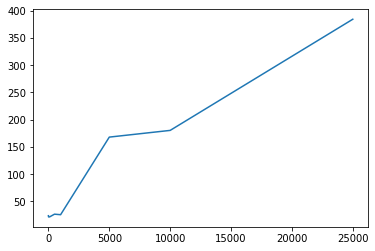

In [13]:
plt.plot(num_steps_to_train_ppo2, mean_rewards_ppo2)
plt.show()

Seems we can get away with 10,000 of training using PPO2 for CarPole-V1. I'm interested to see how it compares to DQN.

In [8]:
from stable_baselines import DQN
from stable_baselines.deepq import MlpPolicy as MlpPolicyDQN

In [9]:
num_steps_to_train_dqn = [0, 10, 100, 500, 1000, 5000, 10_000, 25_000]
mean_rewards_dqn = []
for steps in num_steps_to_train_dqn:
    curr_model_dqn = DQN(MlpPolicyDQN, env_cartpole, verbose=0)
    curr_model_dqn.learn(total_timesteps=steps)
    mean_rewards_dqn.append(np.mean(evaluate_model(curr_model_dqn, env_cartpole, render=False)))

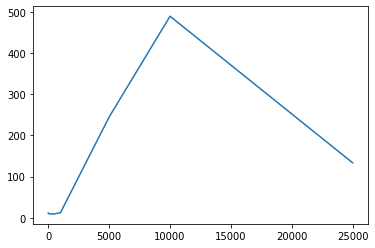

In [11]:
plt.plot(num_steps_to_train_dqn, mean_rewards_dqn)
plt.show()

The DQN performed much better before it seemingly overfit. I'm sure both of these methods could have even better results with some hyperparameter tuning, but we're just trying to get a feel for things for now.